In [5]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict 
from ast import literal_eval
from collections import Counter
import re
import unicodedata
# from py_functions.nlp_preprocessing import *
# from py_functions.topic_modeling import *
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
import spacy
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import textstat
from semantic_text_similarity.models import WebBertSimilarity
# sp_nlp = spacy.load('en_core_web_sm')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

# pd.reset_option('display.max_colwidth')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv("Data/data_NLP_round1.csv")

In [19]:
df[df.title == 'Trump Picks State Department Spokeswoman Heather Nauert As Next UN Ambassador']

number     global_bias  \
930    3108   From the Left   
931    3108  From the Right   

                                                                             title  \
930  Trump Picks State Department Spokeswoman Heather Nauert As Next UN Ambassador   
931  Trump Picks State Department Spokeswoman Heather Nauert As Next UN Ambassador   

                   date  \
930  December 7th, 2018   
931  December 7th, 2018   

                                                                                                               summary  \
930  ["President Trump appoints State Department's Heather Nauert as the next U.S. Ambassador to the United Nations."]   
931  ["President Trump appoints State Department's Heather Nauert as the next U.S. Ambassador to the United Nations."]   

                                                                                                          link  \
930  https://www.allsides.com/story/trump-picks-state-department-spokeswoman-heather-nauert-next-un-ambassador   
931  https://www.allsides.com/story/trump-picks-state-department-spokeswoman-heather-nauert-next-un-ambassador   

                                                                                news_title  \
930  Trump Appoints State Department’s Heather Nauert As U.S. Ambassador To United Nations   
931                    Trump Picks State Department's Heather Nauert as Next UN Ambassador   

                news_source  \
930                HuffPost   
931  Fox News (Online News)   

                                                                                                                news_link  \
930                        https://www.huffingtonpost.com/entry/healther-nauert-un-ambassador_us_5bdb61a7e4b09d43e31d3d4f   
931  http://www1.cbn.com/cbnnews/politics/2018/december/trump-taps-state-departments-heather-nauert-as-next-un-ambassador   

           bias  \
930        Left   
931  Lean Right   

                                                                                                                                              paras  \
930                                                                                The former Fox News host is Trump’s pick to replace Nikki Haley.   
931  President Donald Trump announced he will nominate State Department spokeswoman Heather Nauert to be the next ambassador to the United Nations.   

                                               authors  \
930  ['Andy Campbell', 'Huffpost Us', 'Senior Editor']   
931                                                 []   

                  publish_date  \
930  2018-12-07 06:26:26+05:30   
931  2018-12-07 09:55:32-05:00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   number        1086 non-null   int64 
 1   global_bias   1086 non-null   object
 2   title         1086 non-null   object
 3   date          1086 non-null   object
 4   summary       1086 non-null   object
 5   link          1086 non-null   object
 6   news_title    1086 non-null   object
 7   news_source   1086 non-null   object
 8   news_link     1086 non-null   object
 9   bias          1086 non-null   object
 10  paras         1085 non-null   object
 11  authors       1086 non-null   object
 12  publish_date  808 non-null    object
 13  text          1086 non-null   object
dtypes: int64(1), object(13)
memory usage: 118.9+ KB


In [9]:
df.title.unique()

array(['Trump Administration Drops Citizenship Question From Census',
       'Iran to Surpass Uranium Enrichment Breaching Nuclear Agreement',
       'Social Media Summit Draws Wide Range of Coverage',
       "Trump Tells Congresswomen to 'Go Back' to the Countries They Came From",
       'Hundreds Arrested in Moscow Protests',
       '2 Mass Shootings in 24 Hours',
       'Democrats Descend on Iowa State Fair', 'Obama UN Speech',
       'Death of Jeffrey Epstein in New York Jail Raises Questions',
       'Hong Kong Airport Shut Down Due To Pro-Democracy Protest',
       'Trump Administration Will Delay Tariffs On Some Chinese Goods',
       'Police Standoff With Gunman In Philadelphia Ends',
       'U.S. Issues Warrant to Seize Iran Oil Tanker',
       'Protest Face Off Between Far Left and Right Groups in Portland',
       'President Trump Postpones Trip to Denmark',
       'Joe Walsh Announces He Will Run in Republican Primary',
       'Boris Johnson Suspends Parliament Ahead Of Bre

In [43]:
df_expanded = pd.read_csv('Data/paras_expanded_ready_for_modeling.csv')
df_sentences = pd.read_csv('Data/sent_expanded_ready_for_modeling.csv')

In [45]:
df_expanded.head()

,index,article,number,global_bias,title,news_source,text_ascii,text_paras,para_count,text_paras_lemma,text_paras_misc_clean,text_paras_stopwords,text_paras_no_small_words,text_final
0,0,0,5,From the Left,Trump Administration Drops Citizenship Questio...,HuffPost,A very sad time for America when the Supreme C...,A very sad time for America when the Supreme C...,0,a very sad time for America when the Supreme C...,a very sad time for america when the supreme c...,sad time america supreme court united states a...,sad time america supreme court united states a...,sad time america supreme court united states a...
1,1,0,5,From the Left,Trump Administration Drops Citizenship Questio...,HuffPost,A very sad time for America when the Supreme C...,President Donald Trump spoke out Tuesday on hi...,1,President Donald Trump speak out Tuesday on a...,president donald trump speak out tuesday on a...,president donald trump speak tuesday administr...,president donald trump speak tuesday administr...,president donald trump speak tuesday administr...
2,2,0,5,From the Left,Trump Administration Drops Citizenship Questio...,HuffPost,A very sad time for America when the Supreme C...,A very sad time for America when the Supreme C...,2,a very sad time for America when the Supreme C...,a very sad time for america when the supreme c...,sad time america supreme court united states a...,sad time america supreme court united states a...,sad time america supreme court united states a...
3,3,0,5,From the Left,Trump Administration Drops Citizenship Questio...,HuffPost,A very sad time for America when the Supreme C...,....to do whatever is necessary to bring this ...,3,.... to do whatever be necessary to bring this...,to do whatever be necessary to bring this mos...,whatever necessary bring vital question import...,whatever necessary bring vital question import...,whatever necessary bring vital question import...
4,4,0,5,From the Left,Trump Administration Drops Citizenship Questio...,HuffPost,A very sad time for America when the Supreme C...,"Commerce Secretary Wilbur Ross, who oversees t...",4,"Commerce Secretary Wilbur Ross , who oversee t...",commerce secretary wilbur ross who oversee th...,commerce secretary wilbur ross oversee us cens...,commerce secretary wilbur ross oversee census ...,commerce secretary wilbur ross oversee census ...


In [10]:
polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

In [55]:
df_news = df_expanded.groupby(['number','global_bias'], as_index = False).agg({'title':(lambda x: x.iloc[0]), 'news_source':(lambda x: x.iloc[0]),
                                                   'text_ascii':(lambda x: x.iloc[0]),'text_final':(lambda x: ','.join(x))})

In [12]:
df_news = df_expanded.drop_duplicates(subset=['number','global_bias'], ignore_index=True)

In [13]:
df_news['polar'] = df_news.text_ascii.map(polarity)
df_news['subje'] = df_news.text_ascii.map(subjectivity)

<ipython-input-13-1f7b4a1e3787>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['polar'] = df_news.text_ascii.map(polarity)
<ipython-input-13-1f7b4a1e3787>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['subje'] = df_news.text_ascii.map(subjectivity)


In [ ]:
# count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))

In [ ]:
df_news.groupby('global_bias')

In [20]:
df_news.news_source.value_counts()

Washington Times          275
Fox News (Online News)    266
Washington Post           217
New York Times (News)     202
HuffPost                  122
Name: news_source, dtype: int64

(0.1, 0.6)

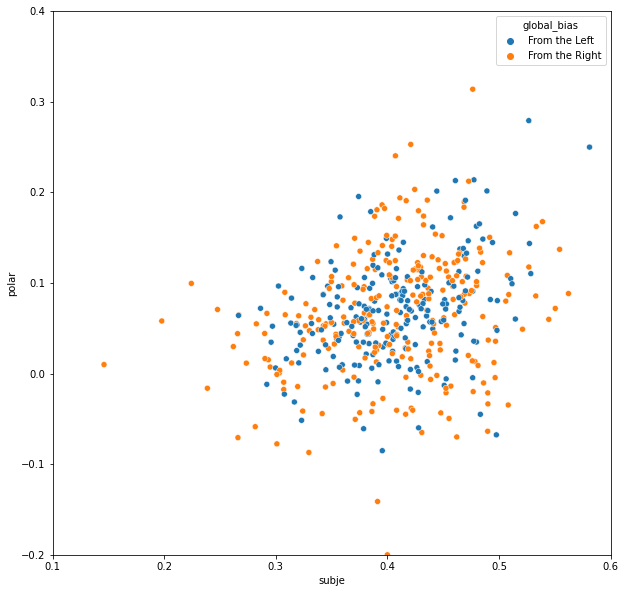

In [24]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='subje', y = 'polar', data=df_news[(df_news.news_source == 'Fox News (Online News)') | (df_news.news_source == 'Washington Post')], hue = 'global_bias')
plt.ylim([-0.2,0.4])
plt.xlim([0.1,0.6])

In [56]:
# df_news['grade_level'] = df_news.text_ascii.map(textstat.text_standard)

518    10th and 11th grade
506    32nd and 33rd grade
Name: text_ascii, dtype: object

In [40]:
df_news[df_news.news_source == 'New York Times (News)'].grade_level.value_counts()

# sns.barplot(x='grade_level', y='grade_level' ,data = df_news[df_news.news_source == 'New York Times (News)'])

-1th and 0th grade    202
Name: grade_level, dtype: int64

In [116]:
pd.set_option('display.max_colwidth', None)

df_news.title.sample()

969    Trump Grounds Military Aircraft For Pelosi's Foreign Trip
Name: title, dtype: object

In [78]:
df_news[df_news.number == 1353][['number','global_bias','title','news_source','text_ascii']].values

array([[1353, 'From the Left', 'Detroit Bankruptcy',
        'New York Times (News)',
        'DETROIT  Detroit, the cradle of Americas automobile industry and once the nations fourth-most-populous city, filed for bankruptcy on Thursday, the largest American city ever to take such a course.\n\nThe decision, confirmed by officials after it trickled out in late afternoon news reports, also amounts to the largest municipal bankruptcy filing in American history in terms of debt. \n\nThis is a difficult step, but the only viable option to address a problem that has been six decades in the making, said Gov. Rick Snyder, who authorized the move after a recommendation from the emergency financial manager he had appointed to resolve Detroits dire financial situation. \n\nNot everyone agrees how much Detroit owes, but Kevyn D. Orr, the emergency manager, has said the debt is likely to be $18 billion and perhaps as much as $20 billion.\n\nFor Detroit, the filing came as a painful reminder of a ci

In [64]:
df_news[df_news.number == 2501]

number     global_bias  \
762    2501   From the Left   
763    2501  From the Right   

                                                            title  \
762  Pennsylvania Court Rules Gerrymandered Maps Unconstitutional   
763  Pennsylvania Court Rules Gerrymandered Maps Unconstitutional   

          news_source  \
762          HuffPost   
763  Washington Times   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [93]:
df_news.iloc[580][['number','global_bias','title','news_source','text_ascii']]

number                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  